## Loading Packages

In [1]:
from fbprophet import Prophet
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from utils import *
import warnings

# plt.style.use('dark_background')
warnings.filterwarnings("ignore")

## Loading Data

In [2]:
def universe_select(path, commodity_name):
    """Selects the instruments believed to be of
    interest for the commodity selected
    Returns: A dictionary of dataframes which are
    intruments of interest"""
    universe_dict = {}
    
    if commodity_name == "Al": 
        aluminium_list = ["al_shfe", "al_lme", "al_comex_p", "al_comex_s", "al_lme_s", "yuan",
                 "bdi", "ted", "vix", "skew", "gsci"]
        
        for instrument in aluminium_list:
            df = pd.read_csv(path + instrument + ".csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)
            universe_dict[instrument] = df
            
    elif commodity_name == "Cu":
        copper_list = ["cu_shfe", "cu_lme", "cu_comex_p", "cu_comex_s", "peso", "sol",
                 "bdi", "ted", "vix", "skew", "gsci"]
        
        for instrument in copper_list:
            df = pd.read_csv(path + instrument + ".csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)
            universe_dict[instrument] = df
    
    else: print("Select an appropriate commodity")
    return universe_dict


In [3]:
path = "Data/"
universe_dict = universe_select(path, "Cu")

## Preprocessing

In [4]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)
# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)
# Making sure that all the points in the window have consistent lenght
universe_dict = truncate_window_length(universe_dict)
# Generate the full training dataset
df_full = generate_dataset(universe_dict, lg_returns_only=True)

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci


In [5]:
# Visualise the plots
# visualise_universe(universe_dict)
df = df_full["lg_return_cu_lme"]

In [6]:
# print(df_full.head())
print(df.head())

date
2006-08-29    0.000000
2006-08-30    0.007395
2006-08-31    0.033459
2006-09-01   -0.014616
2006-09-04    0.008117
Name: lg_return_cu_lme, dtype: float64


## Additive Model

In [7]:
model = Prophet()

In [8]:
d = {"ds":df.index, "y":df}
df = pd.DataFrame(data=d)
df.reset_index(inplace=True)
df = df.drop('date', 1)
df['orig_y'] = df['y'] 

print(df.head())

          ds         y    orig_y
0 2006-08-29  0.000000  0.000000
1 2006-08-30  0.007395  0.007395
2 2006-08-31  0.033459  0.033459
3 2006-09-01 -0.014616 -0.014616
4 2006-09-04  0.008117  0.008117


In [9]:
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


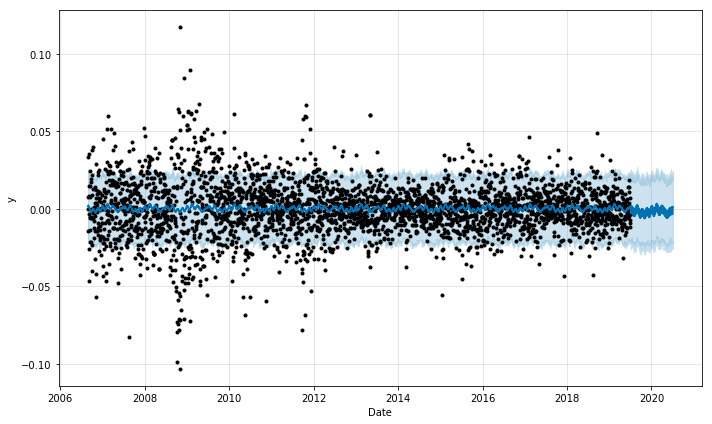

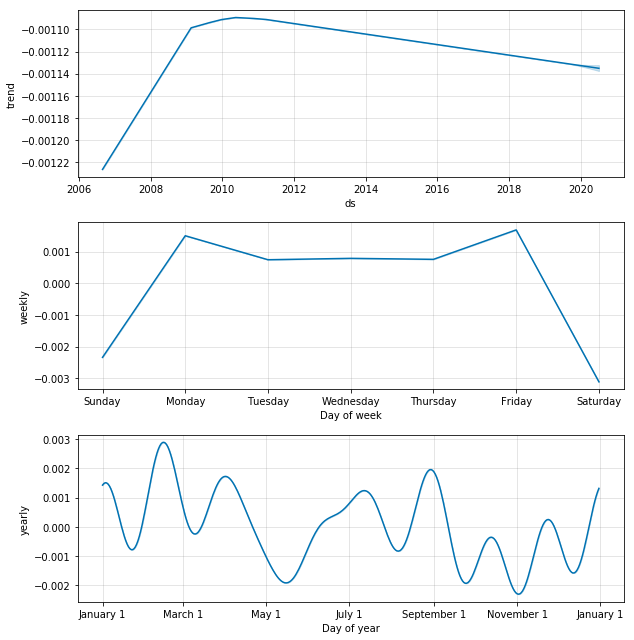

In [10]:
fig_forecast = model.plot(forecast,  xlabel='Date')
fig_components = model.plot_components(forecast)

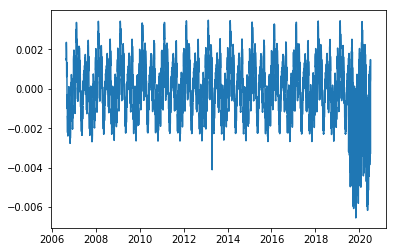

In [38]:
forecast.head()
plt.plot(forecast.ds, forecast.yhat)